#Introduction

In this notebook, we used a network composed of 5 convolutional blocks, composed by a convolution and a pool each, plus two fully connected layers with dropout. We have done some **modification to the dataset**:


*   We split the dataset with our script in:
    *   $75$% training set
    *   $15$% validation set
    *   $10$% test set
*   We balanced the dataset with the script made by us. We set $550$ as threshold for the training set, while $250$ for the validation set. We did not change the test set.

**Augmentation**:

*   We applied data augmentation, in order to avoid overfitting due to some classes which had really few samples in them, like the Raspberry one. This helped also to "fill" a little bit the gap due to the difference of our sets and the test set on the server.
*   Moreover, we noticed that the backgrounds of the leaves were all (or at least, most of them), black. We randomly wanted to set them to white, with a certain probability. We performed an error: instead of making them white, $\left[255;255;255\right]$, we set them at $\left[1;1;1\right]$. We kept also this result, because this allowed us to do further considerations in the final report



**Patience** was set to $10$, and **Learning Rate** to $0,0001$.

With this notebook we got a score of a little bit less than $70$%

We submitted a second version of this notebook with **patience** = $20$, and with that we got a score of $73,96$%

#Mounting Drive

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Checking which GPU I am running on

In [ ]:
!nvidia-smi

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 8.0 MB/s 


#Loading data & folder Exploring

Extracting the zipped archive into the folder in which I am when I start the notebook (/content). We did this, because by extracting the zipped archive in the local folder of the runtime, speeds up a lot the first epoch in google Colab, and make its duration as shord as the following ones. This allowed us to save a lot of GPU time.

In [ ]:
!unzip /gdrive/MyDrive/AN2DL/leaves_test_overUnder_sampled.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02033.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01856.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01704.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01880.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02206.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02218.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01849.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/0_02151.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/1_01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/2_02222.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/3_01720.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/4_01745.jpg  
  inflating: leaves_test_overUnder_sampled/

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'leaves_test_overUnder_sampled' #"leaves_test" is splitted like 75% train, 15% validation, 10%test for each class. "leaves_notest" is splitted like: 80% train, 20% validation, in case it's needed

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') #to be commented if you use the dir "_notest" (not recommended)

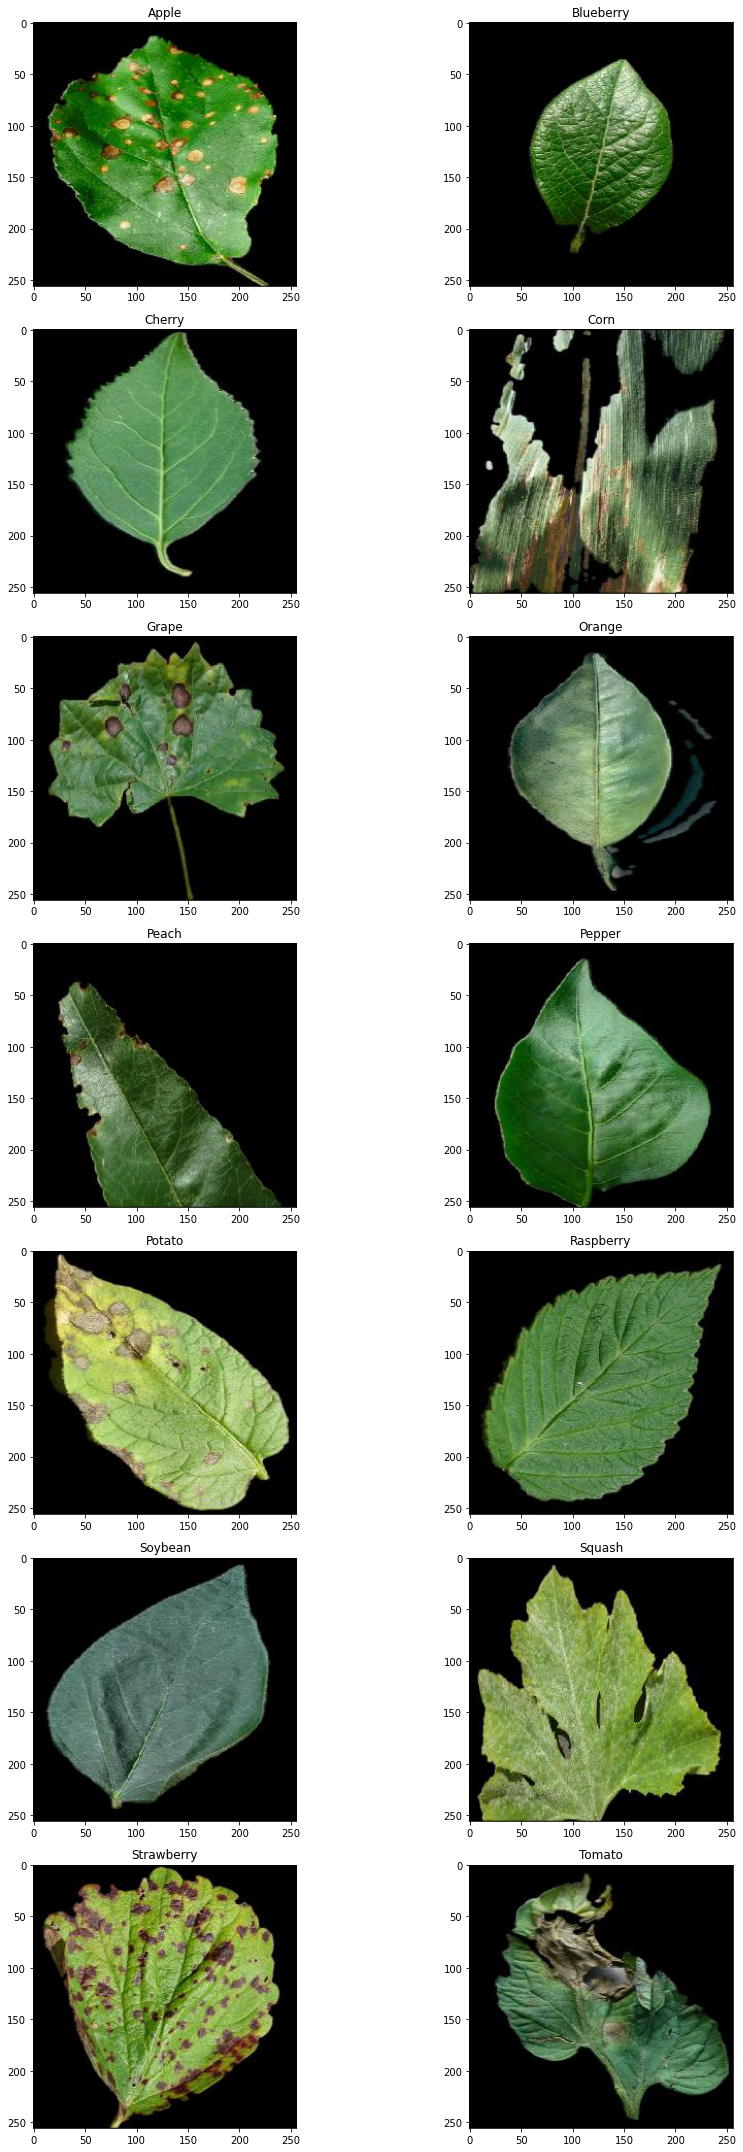

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (leaves_test_overUnder_sampled)")
print("-------")
!ls leaves_test_overUnder_sampled
print()
print("Depth 1 (e.g., leaves_test_overUnder_sampled/training)")
print("------------------------")
!ls leaves_test_overUnder_sampled/train
print()
print("Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)")
print("----------------------------")
!ls leaves_test_overUnder_sampled/train/Blueberry

Depth 0 (leaves_test_overUnder_sampled)
-------
test  train  val

Depth 1 (e.g., leaves_test_overUnder_sampled/training)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)
----------------------------
0_01840.jpg  01827.jpg	02005.jpg  02190.jpg		180_02029.jpg
01647.jpg    01828.jpg	02006.jpg  02191.jpg		18_01953.jpg
01649.jpg    01829.jpg	02007.jpg  02193.jpg		181_01653.jpg
01650.jpg    01830.jpg	02008.jpg  02195.jpg		182_14_01953.jpg
01652.jpg    01831.jpg	02009.jpg  02196.jpg		183_02081.jpg
01653.jpg    01832.jpg	02012.jpg  02197.jpg		184_01996.jpg
01654.jpg    01833.jpg	02014.jpg  02198.jpg		185_01973.jpg
01655.jpg    01835.jpg	02015.jpg  02199.jpg		186_01890.jpg
01656.jpg    01837.jpg	02019.jpg  02203.jpg		187_125_02212.jpg
01657.jpg    01838.jpg	02022.jpg  02205.jpg		188_02127.jpg
01658.jpg    01840.jpg	02023.jpg  022

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from random import randint

Defining a pre processing function which changes the color of the background randomly.

In [ ]:
def change_background(image):
    image = np.array(image)
    if random.random() > 0.4:
      image[image[:, :, 0] <= 10] = 1 #change background color
    return image

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        preprocessing_function=change_background, #Makes our custom function to be called during data augmentation
                                        rescale=1/255.)
aug_valid_data_gen = ImageDataGenerator(rotation_range=180, # --- N.B. --- While trying to increase performances, we tried to perform data augmentation also here, because in some classes, like the raspberry one, when we oversampled the validation set, it contained many copies. Doing some researches, we found online that, sometimes, in some specific applications, this helped a little bit and we wanted to try
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.) #to be commented if used with dataset "_notest" (not recommended)





# class_mode parameter not inserted: cathegorical (one hot coding) is the default one, hence, it is not necessary
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,         #to be commented if used with dataset "_notest" (not recommended)
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None,
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7700 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

Let's work first with the network, and then declaring callbacks and checkpoints

In [ ]:
# Model used:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

Function which creates folders for callbacks

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
  #saving checkpoints on drive. We need to change directory, hence, we need ../ to go back of on folder, from /content to /
  #N.B.: after this we don't need to go back, we did not change directory, we worked with the string of the path
  exps_dir = os.path.join('../gdrive/MyDrive/AN2DL/Checkpts/LucaA') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Building Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

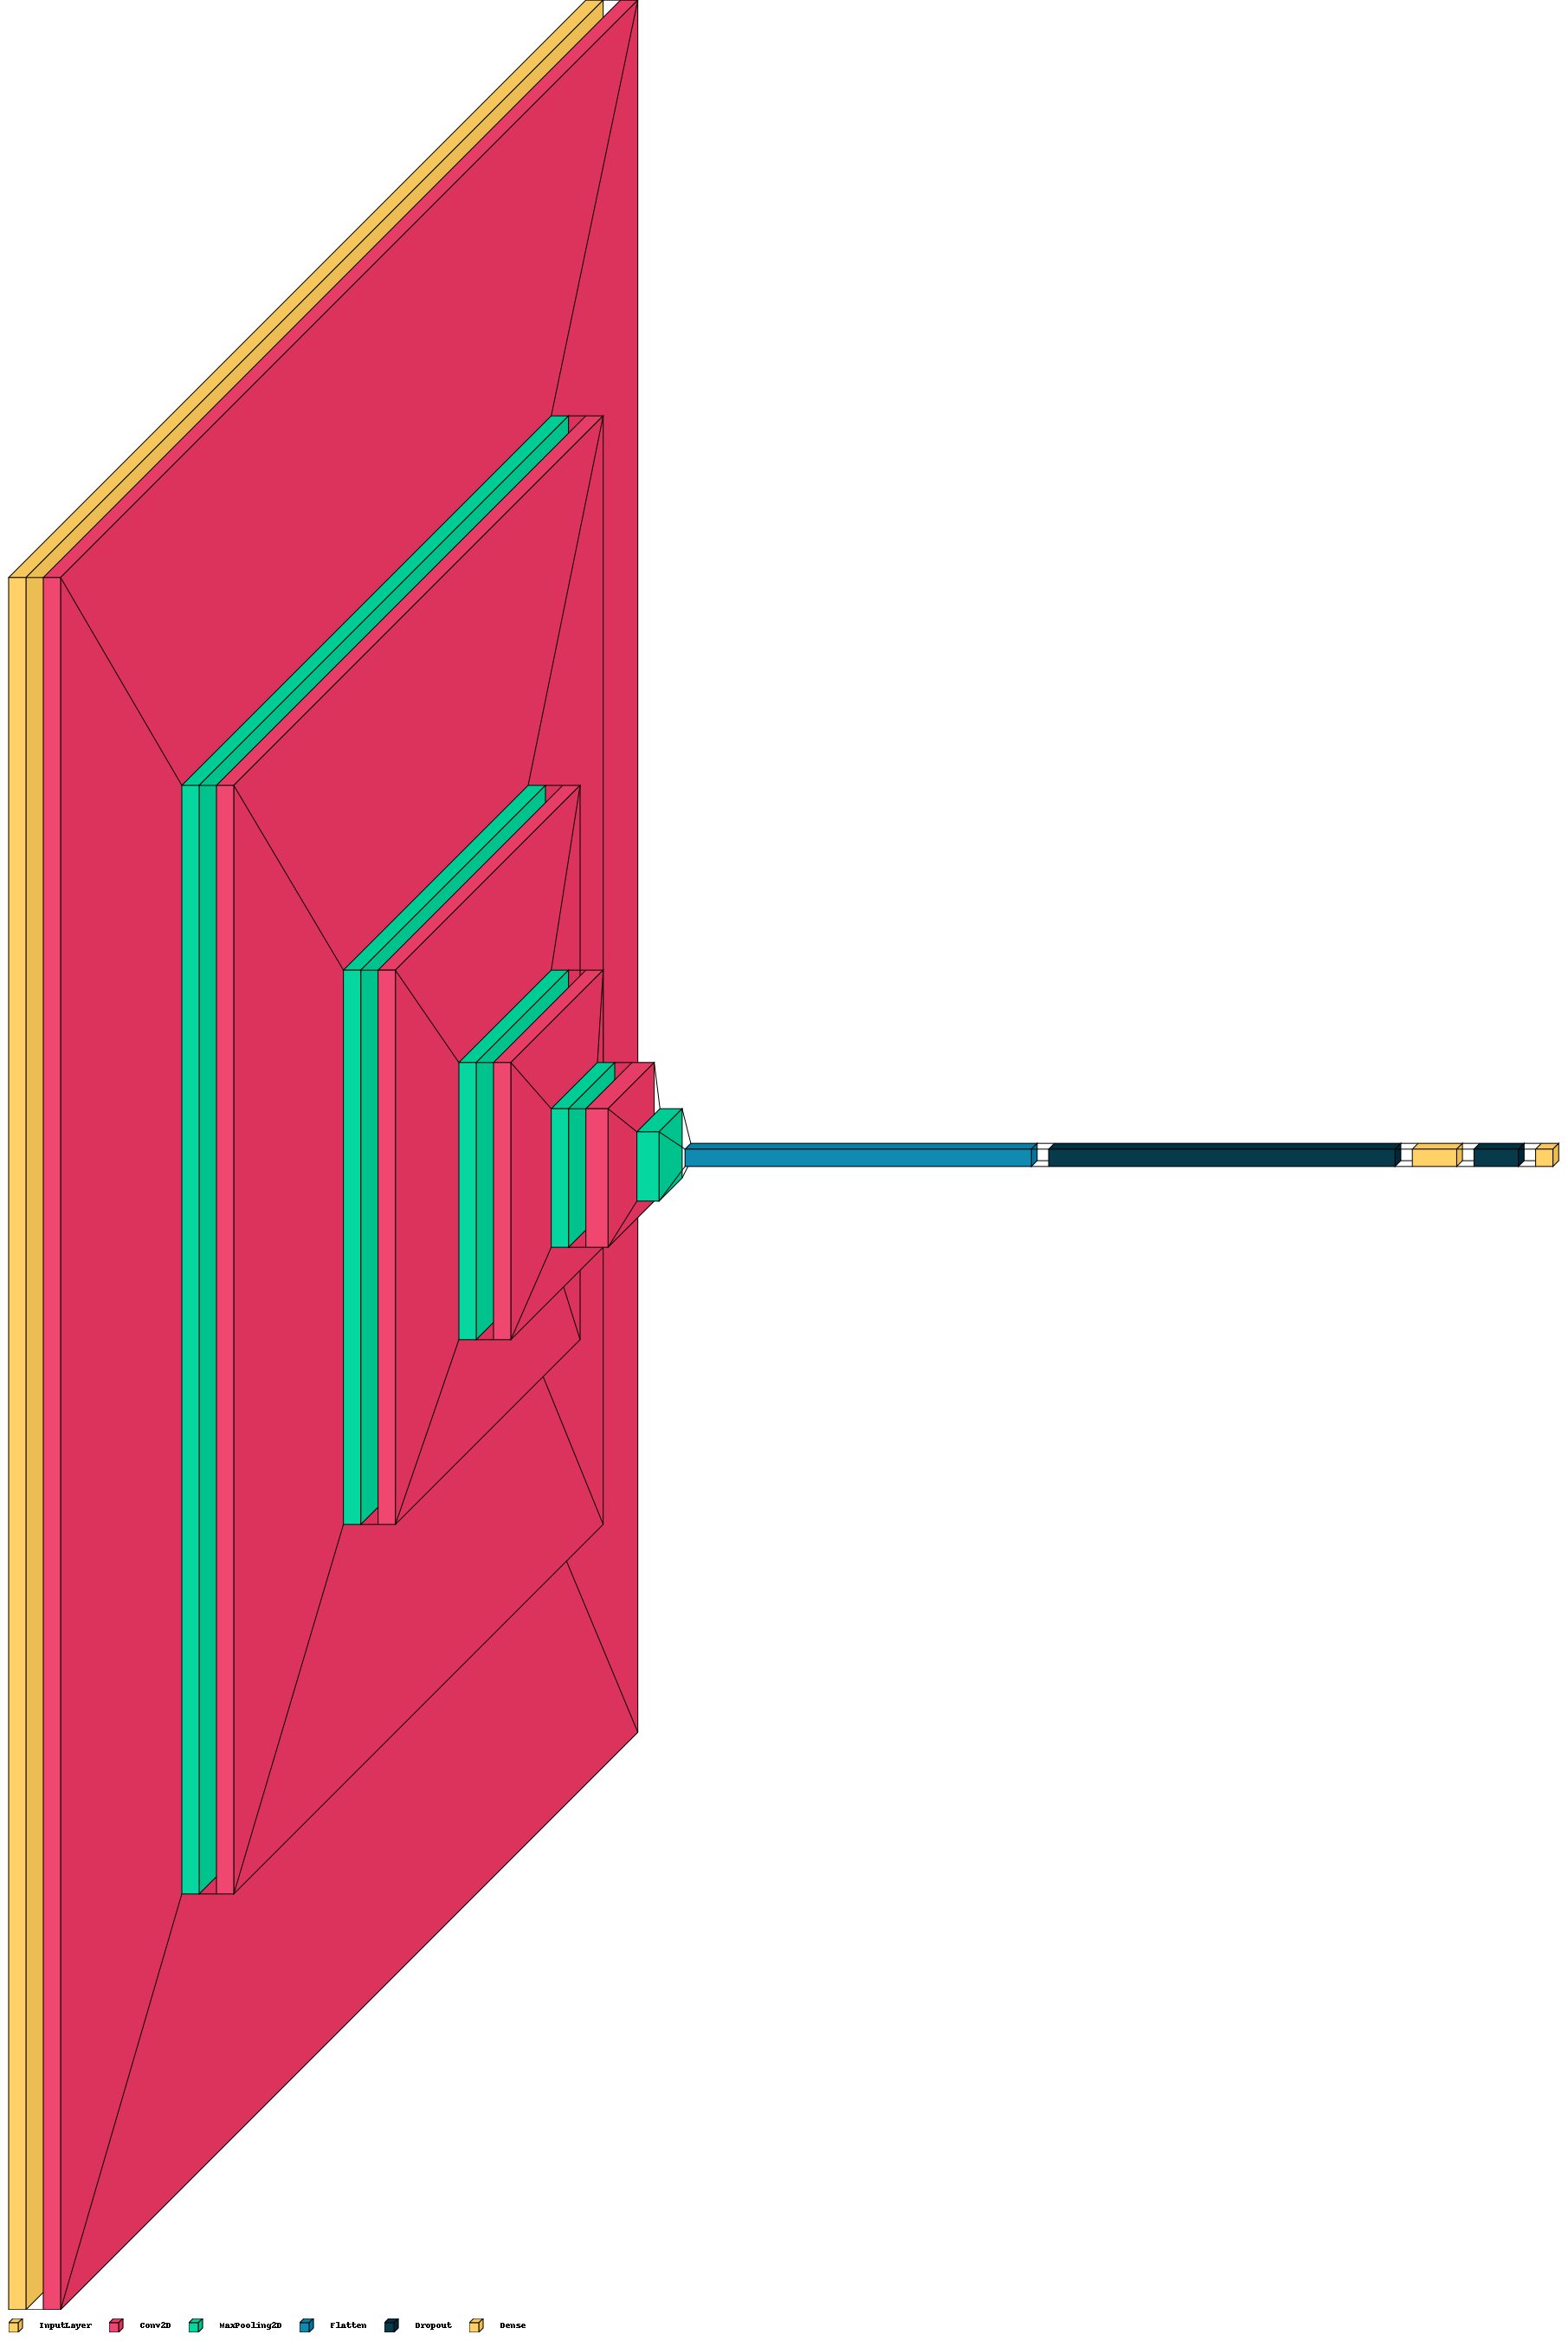

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

#Training the model

In [ ]:
# Create folders and callbacks and fit
aug_bal_callbacks = create_folders_and_callbacks(model_name = 'aug_balanced_LowLearning_ChangeColor') #the model name will generate the folder of this single experiment

# restore checkpoints: (uncomment if needed)
#model.load_weights('/gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_10-10-02/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = aug_bal_callbacks,
).history

Epoch 1/200
963/963 [==============================] - ETA: 0s - loss: 2.3067 - accuracy: 0.2162

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 152s 141ms/step - loss: 2.3067 - accuracy: 0.2162 - val_loss: 1.8800 - val_accuracy: 0.3663
Epoch 2/200
963/963 [==============================] - ETA: 0s - loss: 1.7812 - accuracy: 0.3988

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 1.7812 - accuracy: 0.3988 - val_loss: 1.5552 - val_accuracy: 0.4954
Epoch 3/200
963/963 [==============================] - ETA: 0s - loss: 1.4833 - accuracy: 0.5006

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 1.4833 - accuracy: 0.5006 - val_loss: 1.3010 - val_accuracy: 0.5611
Epoch 4/200
963/963 [==============================] - ETA: 0s - loss: 1.3180 - accuracy: 0.5613

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 136s 141ms/step - loss: 1.3180 - accuracy: 0.5613 - val_loss: 1.1902 - val_accuracy: 0.5911
Epoch 5/200
963/963 [==============================] - ETA: 0s - loss: 1.2167 - accuracy: 0.5945

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 1.2167 - accuracy: 0.5945 - val_loss: 1.0832 - val_accuracy: 0.6406
Epoch 6/200
963/963 [==============================] - ETA: 0s - loss: 1.1063 - accuracy: 0.6326

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 1.1063 - accuracy: 0.6326 - val_loss: 1.0920 - val_accuracy: 0.6394
Epoch 7/200
963/963 [==============================] - ETA: 0s - loss: 1.0272 - accuracy: 0.6665

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 1.0272 - accuracy: 0.6665 - val_loss: 0.9467 - val_accuracy: 0.6911
Epoch 8/200
963/963 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.6735

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 136s 142ms/step - loss: 0.9902 - accuracy: 0.6735 - val_loss: 0.8878 - val_accuracy: 0.7137
Epoch 9/200
963/963 [==============================] - ETA: 0s - loss: 0.9076 - accuracy: 0.7039

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.9076 - accuracy: 0.7039 - val_loss: 0.8260 - val_accuracy: 0.7211
Epoch 10/200
963/963 [==============================] - ETA: 0s - loss: 0.8601 - accuracy: 0.7203

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.8601 - accuracy: 0.7203 - val_loss: 0.7875 - val_accuracy: 0.7403
Epoch 11/200
963/963 [==============================] - ETA: 0s - loss: 0.8094 - accuracy: 0.7399

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.8094 - accuracy: 0.7399 - val_loss: 0.7310 - val_accuracy: 0.7640
Epoch 12/200
963/963 [==============================] - ETA: 0s - loss: 0.7620 - accuracy: 0.7497

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.7620 - accuracy: 0.7497 - val_loss: 0.7176 - val_accuracy: 0.7549
Epoch 13/200
963/963 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.7671

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.7266 - accuracy: 0.7671 - val_loss: 0.7122 - val_accuracy: 0.7657
Epoch 14/200
963/963 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.7739

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.6940 - accuracy: 0.7739 - val_loss: 0.6416 - val_accuracy: 0.7837
Epoch 15/200
963/963 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.7873

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 136s 141ms/step - loss: 0.6487 - accuracy: 0.7873 - val_loss: 0.7450 - val_accuracy: 0.7617
Epoch 16/200
963/963 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.7957

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 141ms/step - loss: 0.6148 - accuracy: 0.7957 - val_loss: 0.5676 - val_accuracy: 0.8134
Epoch 17/200
963/963 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.8035

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.5946 - accuracy: 0.8035 - val_loss: 0.4860 - val_accuracy: 0.8409
Epoch 18/200
963/963 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.8169

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.5632 - accuracy: 0.8169 - val_loss: 0.5084 - val_accuracy: 0.8377
Epoch 19/200
963/963 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.8203

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.5489 - accuracy: 0.8203 - val_loss: 0.4618 - val_accuracy: 0.8489
Epoch 20/200
963/963 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.8339

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.5194 - accuracy: 0.8339 - val_loss: 0.4683 - val_accuracy: 0.8440
Epoch 21/200
963/963 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8355

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.4971 - accuracy: 0.8355 - val_loss: 0.4935 - val_accuracy: 0.8374
Epoch 22/200
963/963 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.8526

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 136s 141ms/step - loss: 0.4715 - accuracy: 0.8526 - val_loss: 0.4757 - val_accuracy: 0.8420
Epoch 23/200
963/963 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8510

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 137s 142ms/step - loss: 0.4583 - accuracy: 0.8510 - val_loss: 0.4503 - val_accuracy: 0.8449
Epoch 24/200
963/963 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8477

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 136s 141ms/step - loss: 0.4519 - accuracy: 0.8477 - val_loss: 0.4795 - val_accuracy: 0.8426
Epoch 25/200
963/963 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.8632

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 139ms/step - loss: 0.4169 - accuracy: 0.8632 - val_loss: 0.3698 - val_accuracy: 0.8717
Epoch 26/200
963/963 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8683

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 139ms/step - loss: 0.4003 - accuracy: 0.8683 - val_loss: 0.4517 - val_accuracy: 0.8509
Epoch 27/200
963/963 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.8721

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 139s 144ms/step - loss: 0.4007 - accuracy: 0.8721 - val_loss: 0.3613 - val_accuracy: 0.8860
Epoch 28/200
963/963 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8778

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 135s 140ms/step - loss: 0.3786 - accuracy: 0.8778 - val_loss: 0.3778 - val_accuracy: 0.8786
Epoch 29/200
963/963 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8758

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 139ms/step - loss: 0.3793 - accuracy: 0.8758 - val_loss: 0.3673 - val_accuracy: 0.8763
Epoch 30/200
963/963 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8845

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 139ms/step - loss: 0.3595 - accuracy: 0.8845 - val_loss: 0.2920 - val_accuracy: 0.9060
Epoch 31/200
963/963 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8855

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.3447 - accuracy: 0.8855 - val_loss: 0.3418 - val_accuracy: 0.8840
Epoch 32/200
963/963 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8870

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.3410 - accuracy: 0.8870 - val_loss: 0.2887 - val_accuracy: 0.9043
Epoch 33/200
963/963 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8877

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.3396 - accuracy: 0.8877 - val_loss: 0.3164 - val_accuracy: 0.8860
Epoch 34/200
963/963 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8957

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 139ms/step - loss: 0.3257 - accuracy: 0.8957 - val_loss: 0.3304 - val_accuracy: 0.8863
Epoch 35/200
963/963 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8968

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 138ms/step - loss: 0.3121 - accuracy: 0.8968 - val_loss: 0.2625 - val_accuracy: 0.9177
Epoch 36/200
963/963 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8974

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.3016 - accuracy: 0.8974 - val_loss: 0.3030 - val_accuracy: 0.9049
Epoch 37/200
963/963 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8958

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.3042 - accuracy: 0.8958 - val_loss: 0.2773 - val_accuracy: 0.9066
Epoch 38/200
963/963 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9077

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2866 - accuracy: 0.9077 - val_loss: 0.3810 - val_accuracy: 0.8714
Epoch 39/200
963/963 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.9109

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2787 - accuracy: 0.9109 - val_loss: 0.2799 - val_accuracy: 0.9091
Epoch 40/200
963/963 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.9074

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2818 - accuracy: 0.9074 - val_loss: 0.2984 - val_accuracy: 0.9026
Epoch 41/200
963/963 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9105

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2779 - accuracy: 0.9105 - val_loss: 0.2299 - val_accuracy: 0.9186
Epoch 42/200
963/963 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9171

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2555 - accuracy: 0.9171 - val_loss: 0.2740 - val_accuracy: 0.9069
Epoch 43/200
963/963 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9153

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2560 - accuracy: 0.9153 - val_loss: 0.2696 - val_accuracy: 0.9097
Epoch 44/200
963/963 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9121

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2619 - accuracy: 0.9121 - val_loss: 0.2670 - val_accuracy: 0.9166
Epoch 45/200
963/963 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9179

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2500 - accuracy: 0.9179 - val_loss: 0.3319 - val_accuracy: 0.8931
Epoch 46/200
963/963 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9244

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2420 - accuracy: 0.9244 - val_loss: 0.2460 - val_accuracy: 0.9211
Epoch 47/200
963/963 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9235

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2292 - accuracy: 0.9235 - val_loss: 0.2343 - val_accuracy: 0.9223
Epoch 48/200
963/963 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9274

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2273 - accuracy: 0.9274 - val_loss: 0.2328 - val_accuracy: 0.9237
Epoch 49/200
963/963 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9234

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2354 - accuracy: 0.9234 - val_loss: 0.1887 - val_accuracy: 0.9383
Epoch 50/200
963/963 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9236

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2366 - accuracy: 0.9236 - val_loss: 0.2270 - val_accuracy: 0.9263
Epoch 51/200
963/963 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9282

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2151 - accuracy: 0.9282 - val_loss: 0.2492 - val_accuracy: 0.9200
Epoch 52/200
963/963 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9336

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 139ms/step - loss: 0.2000 - accuracy: 0.9336 - val_loss: 0.2021 - val_accuracy: 0.9349
Epoch 53/200
963/963 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9309

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.2061 - accuracy: 0.9309 - val_loss: 0.2362 - val_accuracy: 0.9223
Epoch 54/200
963/963 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9339

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 140ms/step - loss: 0.1955 - accuracy: 0.9339 - val_loss: 0.2417 - val_accuracy: 0.9194
Epoch 55/200
963/963 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9338

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 140ms/step - loss: 0.1991 - accuracy: 0.9338 - val_loss: 0.1912 - val_accuracy: 0.9349
Epoch 56/200
963/963 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9375

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 137s 142ms/step - loss: 0.1932 - accuracy: 0.9375 - val_loss: 0.2022 - val_accuracy: 0.9309
Epoch 57/200
963/963 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9387

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 139ms/step - loss: 0.1871 - accuracy: 0.9387 - val_loss: 0.2264 - val_accuracy: 0.9211
Epoch 58/200
963/963 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9362

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 134s 139ms/step - loss: 0.1881 - accuracy: 0.9362 - val_loss: 0.1909 - val_accuracy: 0.9380
Epoch 59/200
963/963 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9430

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_Nov18_15-47-57/ckpts/cp.ckpt/assets


963/963 [==============================] - 133s 138ms/step - loss: 0.1745 - accuracy: 0.9430 - val_loss: 0.2245 - val_accuracy: 0.9251


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
# Save best epoch model
model.save("Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor")

INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor/assets


INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor/assets


#Plot training error and validation error

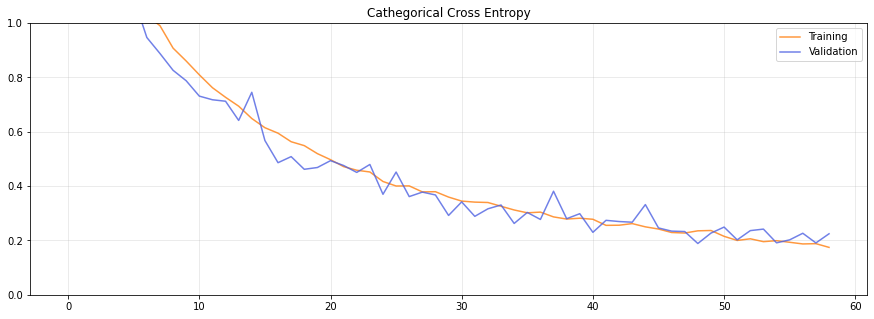

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Cathegorical Cross Entropy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Testing
N.B.: this cells can be executed only if considering the dataset with the test folder (reccommend to use the dataset with the test folder)

In [ ]:
cd /content

/content


In [ ]:
model_to_be_tested = tfk.models.load_model("../gdrive/MyDrive/AN2DL/models/Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)

224/224 [==============================] - 19s 16ms/step - loss: 0.2537 - accuracy: 0.9210


#Further informations on testing

##Printing Activations

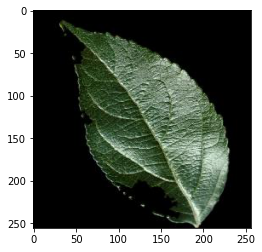

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[3] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [ ]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in model_to_be_tested.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model_to_be_tested.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

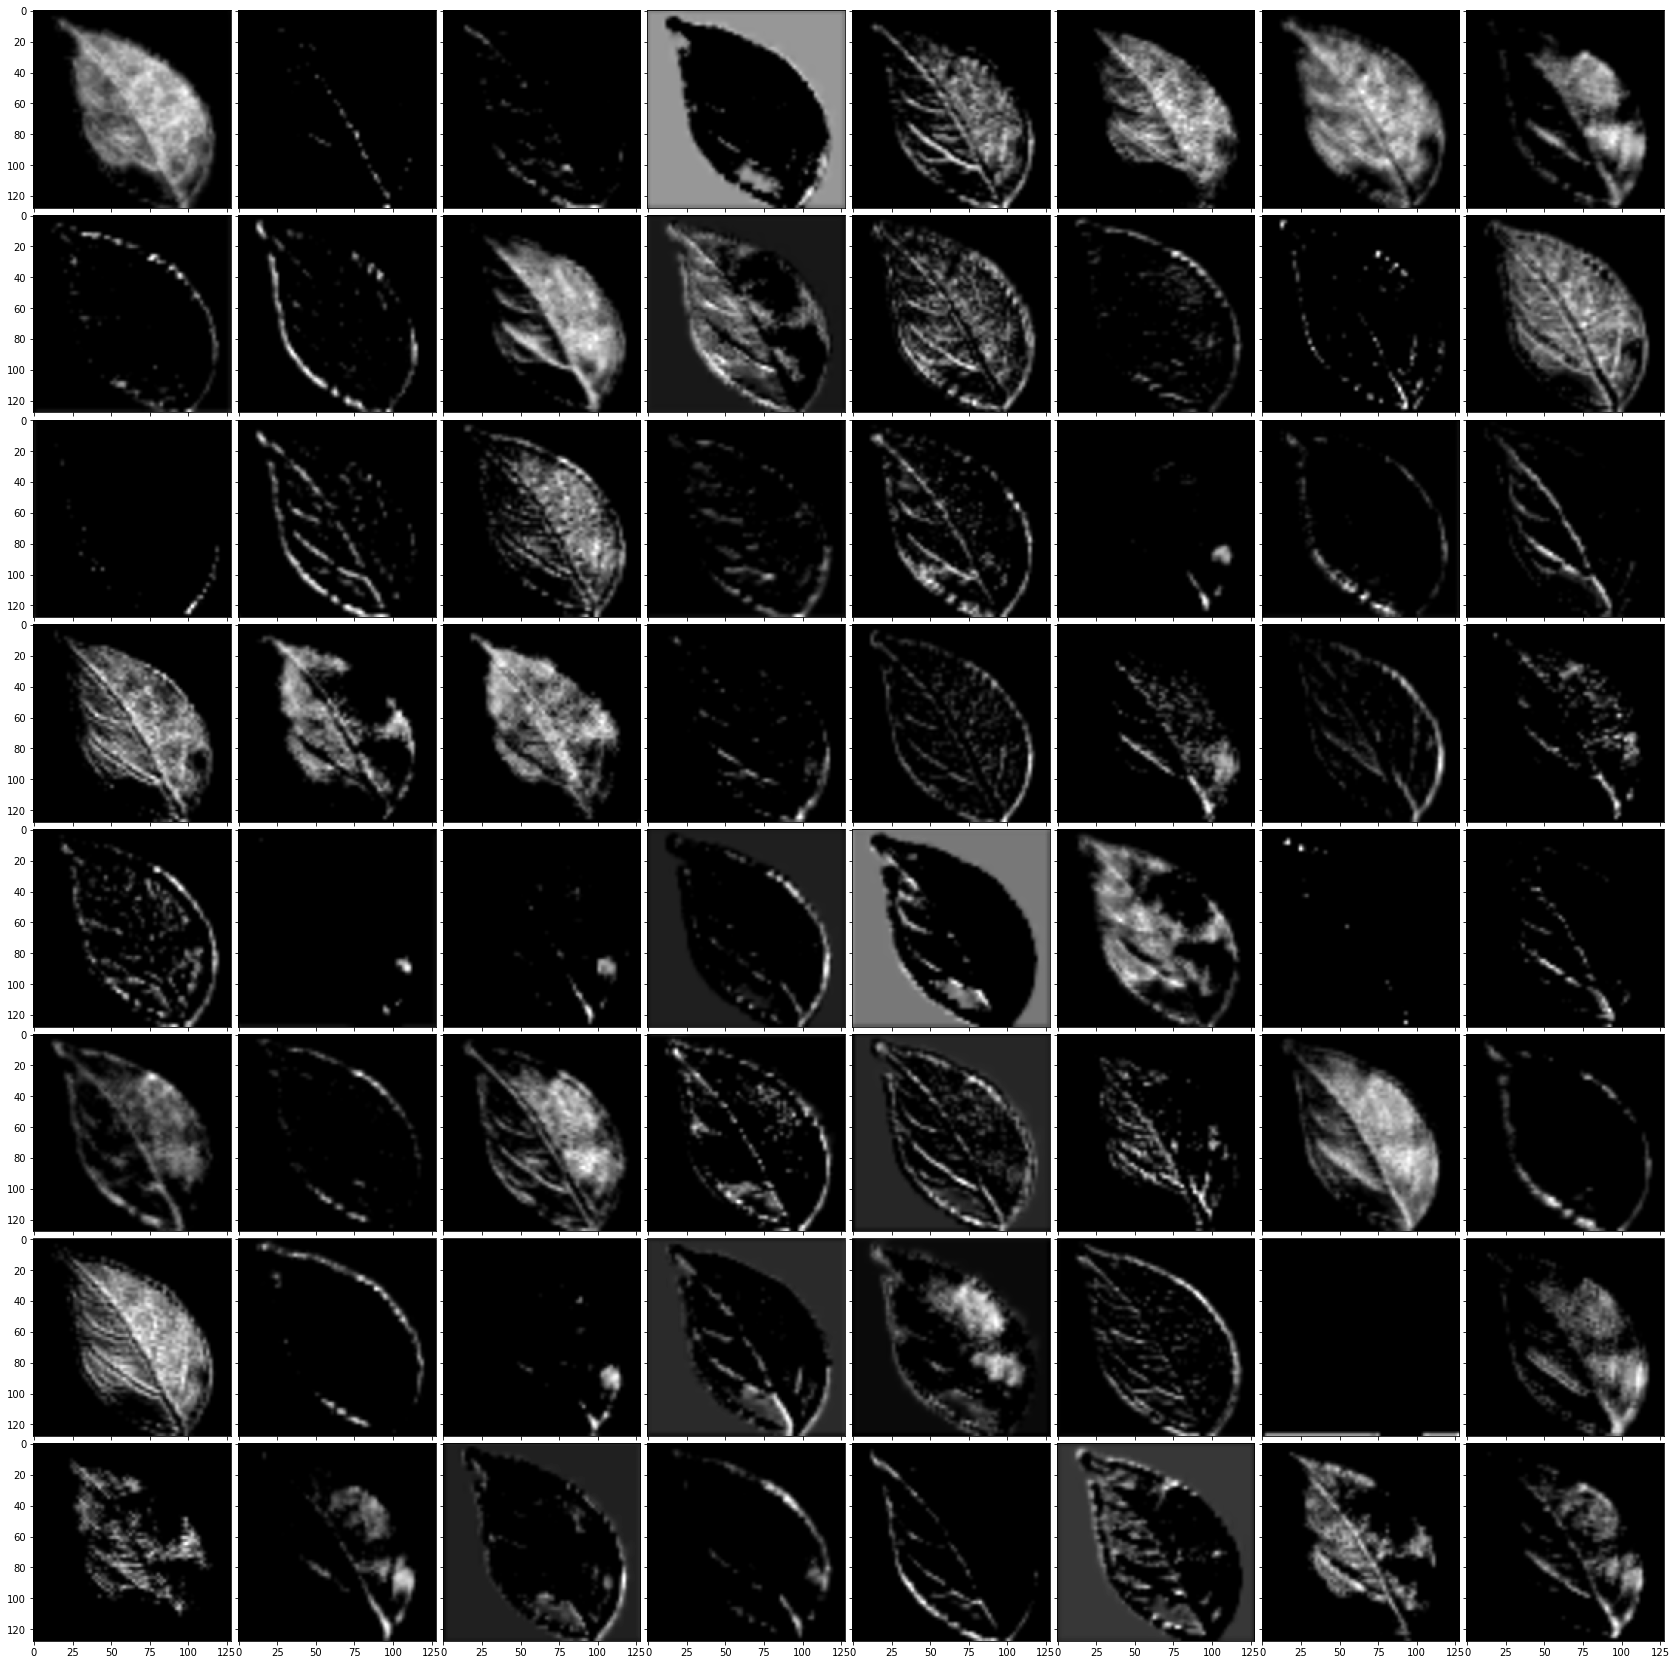

In [ ]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)

##Confusion Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy: 0.921
Precision: 0.9028
Recall: 0.9327
F1: 0.9142


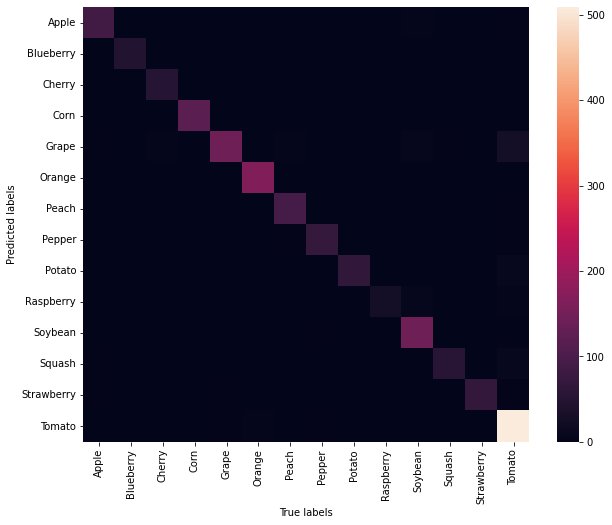

In [ ]:
predictions = model_to_be_tested.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()